# 1. Convolution Neural Network

In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


Problem 1: 
a. Copy and study the starter code (until “ConvNet as fixed feature extractor”) given by 
Sasank (CTO of Qure.ai, pytorch contributor, and alumnus of IITB) for classifying ants 
vs. bees: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. The 
key feature of this code is that it does not train a model from scratch, but uses 
transfer learning of a ResNet-18 architecture that is pre-trained on a large dataset 
(ImageNet) and then only fine-tunes it for the problem at hand.

b. Modify the code to run on co-lab without any new features. [1]

c. Modify the code to plot validation loss and accuracy after every training epoch. [2]

d. Change the learning rate, momentum, and number of epochs at least three times to 
see the net effect on final validation loss and accuracy and its speed of convergence.
https://pytorch.org/docs/stable/optim.html [1]

e. Introduce weight decay (L2 penalty on weights) and find a good value for the weight 
decay factor. [1]


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.

------
(Modified Section)
------

We load the data in Google Drive and mount it to Colab.

In [ ]:
# Code for loading the data from google drive zip format
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive



Note: Google Drive mapping should use '\\' character before space character

In [ ]:
!unzip gdrive/My\ Drive/data1/hymenoptera_data.zip


Archive:  gdrive/My Drive/data1/hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_

------
(Modified Section)
------

Explanation of the data tansforms:

1. Compose allows to chain transformations of images to suite the input for the pretrained Resnet18 model.
2. The image sizes will be croped to 224. 
3. It can be flipped so that the picture is seen from right to left as well. 
4.  Center cropping is used for validation data.
5. This is then converted to the pytorch tensor. 
5. Finally this is normalized, the value of mean and standard deviation for normalization comes from recommendation of imagenet database.

References:
1. https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
## Modified:  Changed path
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


####Visualizing a few images

Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


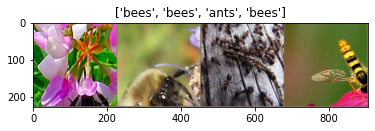

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



----------
(Modified Subsection)

Understanding the train_model function in Pytorch
1.  The base model will be loaded and given as input to train_model function.
2.  criterion applied is Cross Entropy Loss.  Pytorch nn provides this function that can take the predicted output and compute the lost based on the labels (actual) values.  
3. The Backward function is used only during 'training' where gradients are updated.  This is used with Optimizer set to Stochastic Gradient Descent.

-----------------------
(Modified Section)
-----------------------

### Part b

 Modify the code to plot validation loss and accuracy after every training epoch.

$\textbf{Ans}$:
Setup to capture the metrics for plotting.
The tensor is running on GPU to speed training time.
This will have to be moved to CPU memory for plotting.
For each epoch we will plot the validation loss and accuracy.

---------------------------



In [ ]:
## Modified
# Code added to save epoc loss and accuracy
# this can be used for plotting
# c. Modify the code to plot validation loss and accuracy after every training epoch.
num_epochs_cpu = []
val_loss_cpu = []
val_acc_cpu = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    ## Begin Modified
    # clear the metrics list
    val_loss_cpu.clear()
    val_acc_cpu.clear()
    num_epochs_cpu.clear()
    ## end Modified

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            ####
            # Modified : Store val loss and accuracy in list
            # loss.item above already moves loss to CPU from GPU
            # acc.item will do the same below.  This makes it easier
            # to use with Matplotlib
            ####
            if phase == 'val':
              val_loss_cpu.append(epoch_loss)
              val_acc_cpu.append(epoch_acc.item())
              num_epochs_cpu.append(epoch)
            ## End Modified

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




----------
(Modified Section)
----------
Highlights of Resnet 18 pre-trained model: 

1. Number of Layers:    18 (convolution neural network)
2. Training Data Size:  1 million images
3. Object categories classified:  1000
4. Image input size: 224 by 224.

-----------
2.  For bees and ants we have two classes
3.  This will run on GPU device to speed up training.
4.  Criterion:  utilizes cross entropy loss
5.  Optimizer: uses Stochastic Gradient descent optimizing all the parameters, with a learning rate of 0.001 and momentum of 0.9
6. Scheduler:  Every 7 epochs it reduces the learning rate by 0.1






In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6185 Acc: 0.6680
val Loss: 0.3041 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5769 Acc: 0.7582
val Loss: 0.3063 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.6473 Acc: 0.7500
val Loss: 0.9341 Acc: 0.7059

Epoch 3/24
----------
train Loss: 0.6645 Acc: 0.7623
val Loss: 0.5016 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.4188 Acc: 0.8197
val Loss: 0.2846 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.5403 Acc: 0.7664
val Loss: 0.4075 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5111 Acc: 0.8156
val Loss: 0.2966 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4018 Acc: 0.8402
val Loss: 0.2491 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.4196 Acc: 0.8402
val Loss: 0.2542 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2944 Acc: 0.8852
val Loss: 0.2219 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3526 Acc: 0.8566
val Loss: 0.2341 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3847 Acc: 0.8484
val Loss: 0.2402 Acc: 0.9346

Epoch 12/24
----------
t

In [ ]:
val_acc_cpu

[0.8823529411764706,
 0.8823529411764706,
 0.7058823529411765,
 0.8300653594771242,
 0.8823529411764706,
 0.8627450980392157,
 0.9084967320261438,
 0.9084967320261438,
 0.9084967320261438,
 0.9215686274509804,
 0.9150326797385622,
 0.934640522875817,
 0.9281045751633987,
 0.9281045751633987,
 0.9281045751633987,
 0.9150326797385622,
 0.9215686274509804,
 0.9281045751633987,
 0.934640522875817,
 0.9281045751633987,
 0.9281045751633987,
 0.934640522875817,
 0.934640522875817,
 0.9281045751633987,
 0.9281045751633987]

----------------------------
(Modified Section)
----------------------------

### Part c
  The CPU values saved from the tensors can be used to plot the epoc vs. validation accuracy and loss

-------

Create Model will use the parameters that we would like to explore.  These will include a default value,  for example for initial 3 runs we keep the weight decay of 0 and vary the learning rate momentum.  Epochs can be varied in train model time.

Finally we will change the weight decay and observe the convergence

In [ ]:
def create_model ( lr=0.001, momentum=0.9, weight_decay=0):
  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  model_ft.fc = nn.Linear(num_ftrs, 2)

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr, momentum, 
                           weight_decay)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  return model_ft,  optimizer_ft, exp_lr_scheduler, criterion 

In [ ]:
## For parameter set 1
# Learning rate lr=0.001, momentum=0.9, no of epochs 24
num_epochs_cpu1 = num_epochs_cpu.copy()
val_loss_cpu1 = val_loss_cpu.copy()
val_acc_cpu1 = val_loss_cpu.copy()

In [ ]:
def plt_valacc(num_epochs, val_loss, val_acc, title):
  ## plot b, val_loss/val_acc
  plt.subplot(1, 2, 1)
  plt.scatter( num_epochs, val_loss) 
  # We can add labels and title
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(title)

  plt.subplot(1, 2, 2)
  plt.scatter( num_epochs, val_acc) 
  # We can add labels and title
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(title)
  ##  define some spacing between the two sub plots
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2.0, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

  plt.show()  

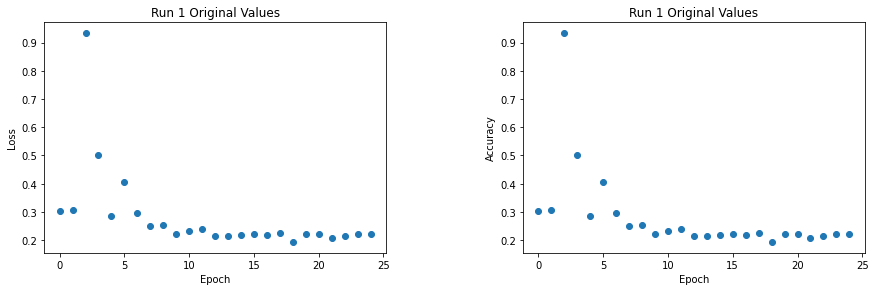

In [ ]:
plt_valacc( num_epochs_cpu1, val_loss_cpu1, val_acc_cpu1, 'Run 1 Original Values')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


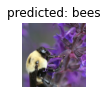

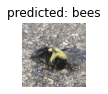

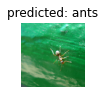

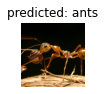

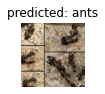

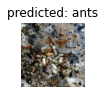

In [ ]:
visualize_model(model_ft)

In [ ]:
# Create and run the Second model
model_ft, optimizer_ft, exp_lr_scheduler, criterion = create_model( lr=0.01, momentum=0.8)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.9512 Acc: 0.5492
val Loss: 13.6555 Acc: 0.4575

Epoch 1/29
----------
train Loss: 1.8755 Acc: 0.4959
val Loss: 1.5236 Acc: 0.5752

Epoch 2/29
----------
train Loss: 1.3558 Acc: 0.5082
val Loss: 4.0789 Acc: 0.5229

Epoch 3/29
----------
train Loss: 1.2109 Acc: 0.4918
val Loss: 2.2834 Acc: 0.5425

Epoch 4/29
----------
train Loss: 1.2358 Acc: 0.5656
val Loss: 2.7992 Acc: 0.5556

Epoch 5/29
----------
train Loss: 1.2941 Acc: 0.5902
val Loss: 3.0905 Acc: 0.5752

Epoch 6/29
----------
train Loss: 1.2459 Acc: 0.5861
val Loss: 0.6050 Acc: 0.6797

Epoch 7/29
----------
train Loss: 0.6859 Acc: 0.6148
val Loss: 0.6408 Acc: 0.7190

Epoch 8/29
----------
train Loss: 0.6557 Acc: 0.6475
val Loss: 0.6167 Acc: 0.7451

Epoch 9/29
----------
train Loss: 0.5995 Acc: 0.7213
val Loss: 0.5805 Acc: 0.7190

Epoch 10/29
----------
train Loss: 0.6148 Acc: 0.6844
val Loss: 0.5801 Acc: 0.7190

Epoch 11/29
----------
train Loss: 0.6074 Acc: 0.6885
val Loss: 0.6900 Acc: 0.6863

Epoch 12/29
----------


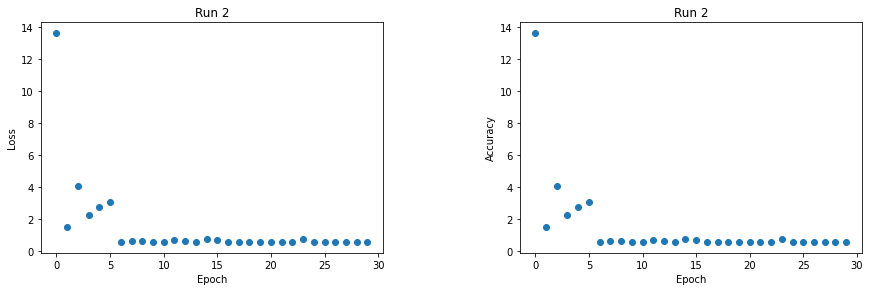

In [ ]:
## Part d: For parameter set 2
# Learning rate lr=0.01, momentum=0.8, no of epochs 30
num_epochs_cpu2 = num_epochs_cpu.copy()
val_loss_cpu2 = val_loss_cpu.copy()
val_acc_cpu2 = val_loss_cpu.copy()
plt_valacc( num_epochs_cpu2, val_loss_cpu2, val_acc_cpu2, 'Run 2')

In [ ]:
# Create and run the Third model
model_ft, optimizer_ft, exp_lr_scheduler, criterion = create_model( lr=0.0001, momentum=0.7)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7138 Acc: 0.5451
val Loss: 0.6254 Acc: 0.6471

Epoch 1/19
----------
train Loss: 0.6029 Acc: 0.6721
val Loss: 0.5604 Acc: 0.7451

Epoch 2/19
----------
train Loss: 0.5948 Acc: 0.7008
val Loss: 0.4639 Acc: 0.8301

Epoch 3/19
----------
train Loss: 0.5443 Acc: 0.7459
val Loss: 0.4290 Acc: 0.8627

Epoch 4/19
----------
train Loss: 0.5315 Acc: 0.7746
val Loss: 0.3933 Acc: 0.8824

Epoch 5/19
----------
train Loss: 0.4810 Acc: 0.8156
val Loss: 0.3602 Acc: 0.8693

Epoch 6/19
----------
train Loss: 0.4613 Acc: 0.8074
val Loss: 0.3410 Acc: 0.8889

Epoch 7/19
----------
train Loss: 0.4715 Acc: 0.7951
val Loss: 0.3405 Acc: 0.9020

Epoch 8/19
----------
train Loss: 0.4562 Acc: 0.8033
val Loss: 0.3437 Acc: 0.8954

Epoch 9/19
----------
train Loss: 0.4879 Acc: 0.7459
val Loss: 0.3269 Acc: 0.8954

Epoch 10/19
----------
train Loss: 0.4567 Acc: 0.8320
val Loss: 0.3342 Acc: 0.9085

Epoch 11/19
----------
train Loss: 0.4890 Acc: 0.7746
val Loss: 0.3200 Acc: 0.9085

Epoch 12/19
----------
t

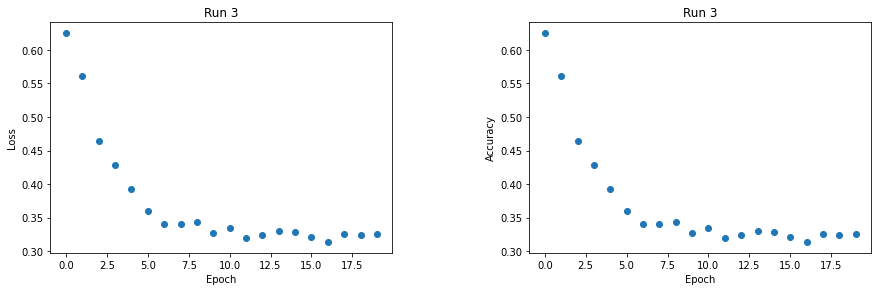

In [ ]:
##Part d: For parameter set 3
# Learning rate lr=0.0001, momentum=0.7, no of epochs 20
num_epochs_cpu3 = num_epochs_cpu.copy()
val_loss_cpu3 = val_loss_cpu.copy()
val_acc_cpu3 = val_loss_cpu.copy()
plt_valacc( num_epochs_cpu3, val_loss_cpu3, val_acc_cpu3, 'Run 3')

In [ ]:
# Create and run the Fourth model
model_ft, optimizer_ft, exp_lr_scheduler, criterion = create_model( lr=0.0005, momentum=0.75)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=35)

Epoch 0/34
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6117 Acc: 0.6557
val Loss: 0.2969 Acc: 0.9281

Epoch 1/34
----------
train Loss: 0.4165 Acc: 0.8238
val Loss: 0.2235 Acc: 0.9281

Epoch 2/34
----------
train Loss: 0.4285 Acc: 0.7869
val Loss: 0.1875 Acc: 0.9412

Epoch 3/34
----------
train Loss: 0.3985 Acc: 0.8033
val Loss: 0.2208 Acc: 0.9150

Epoch 4/34
----------
train Loss: 0.3431 Acc: 0.8320
val Loss: 0.1597 Acc: 0.9477

Epoch 5/34
----------
train Loss: 0.4269 Acc: 0.7705
val Loss: 0.1654 Acc: 0.9542

Epoch 6/34
----------
train Loss: 0.3881 Acc: 0.8197
val Loss: 0.1449 Acc: 0.9542

Epoch 7/34
----------
train Loss: 0.3335 Acc: 0.8443
val Loss: 0.1509 Acc: 0.9477

Epoch 8/34
----------
train Loss: 0.3019 Acc: 0.8607
val Loss: 0.1527 Acc: 0.9542

Epoch 9/34
----------
train Loss: 0.2875 Acc: 0.8730
val Loss: 0.1543 Acc: 0.9346

Epoch 10/34
----------
train Loss: 0.3377 Acc: 0.8607
val Loss: 0.1586 Acc: 0.9412

Epoch 11/34
----------
train Loss: 0.3302 Acc: 0.8443
val Loss: 0.1426 Acc: 0.9542

Epoch 12/34
----------
t

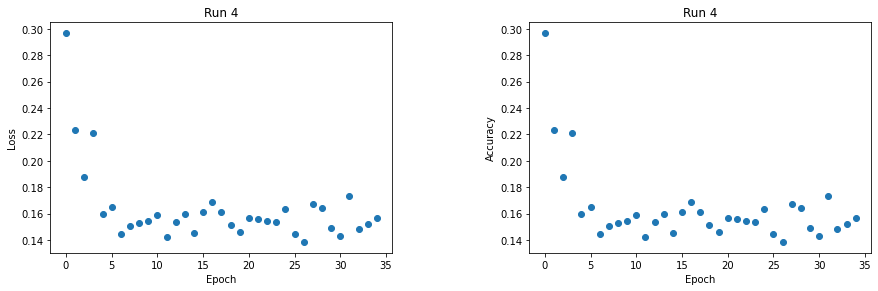

In [ ]:
## Part d: For parameter set 4
# Learning rate lr=0.0001, momentum=0.7, no of epochs 20
num_epochs_cpu4 = num_epochs_cpu.copy()
val_loss_cpu4 = val_loss_cpu.copy()
val_acc_cpu4 = val_loss_cpu.copy()
plt_valacc( num_epochs_cpu4, val_loss_cpu4, val_acc_cpu4, 'Run 4')

-------
(Modified Section)
-------
### Part e

Introduction of the weight decay.

We will train the model with 3 levels fo weight decay.  If the weight decay is too large then it has a risk of overfit and too small weight decay may lead to delayed convergence.
The reference weight decay suggestions are:
* 0.1
* 0.01  (fast.ai recommendation)
* 0.05


references:
1. https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9
https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

In [ ]:
# Create and run the Fifth model with weight decay of 0.1
model_ft, optimizer_ft, exp_lr_scheduler, criterion = create_model( weight_decay=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6187 Acc: 0.7090
val Loss: 0.1889 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6254 Acc: 0.7336
val Loss: 0.2692 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4095 Acc: 0.8320
val Loss: 0.1446 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.6331 Acc: 0.7336
val Loss: 0.2122 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4376 Acc: 0.7992
val Loss: 0.1702 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4954 Acc: 0.8197
val Loss: 0.1943 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3892 Acc: 0.8402
val Loss: 0.2126 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2998 Acc: 0.8648
val Loss: 0.1943 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3583 Acc: 0.8484
val Loss: 0.1710 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3073 Acc: 0.8811
val Loss: 0.1827 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3181 Acc: 0.8689
val Loss: 0.1804 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3515 Acc: 0.8402
val Loss: 0.1839 Acc: 0.9346

Epoch 12/24
----------
t

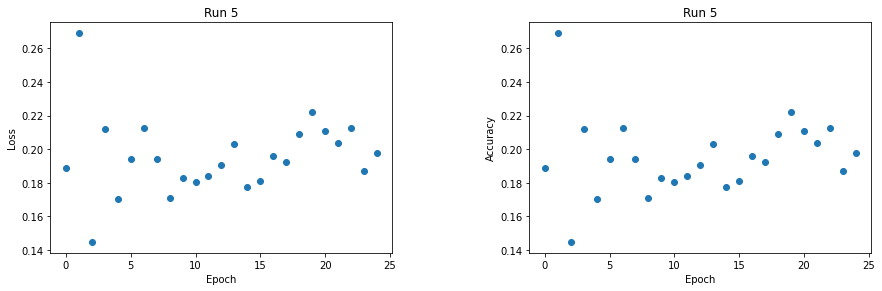

In [ ]:
## Part e: For parameter set 5 weigth decay 0.1
# 
num_epochs_cpu5 = num_epochs_cpu.copy()
val_loss_cpu5 = val_loss_cpu.copy()
val_acc_cpu5 = val_loss_cpu.copy()
plt_valacc( num_epochs_cpu5, val_loss_cpu5, val_acc_cpu5, 'Run 5')

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5540 Acc: 0.6967
val Loss: 0.3316 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.4222 Acc: 0.7869
val Loss: 0.1956 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4017 Acc: 0.7992
val Loss: 0.2486 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3787 Acc: 0.8525
val Loss: 0.1500 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3755 Acc: 0.8279
val Loss: 0.2537 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.3160 Acc: 0.8770
val Loss: 0.2173 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3240 Acc: 0.8811
val Loss: 0.3521 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3159 Acc: 0.8689
val Loss: 0.1986 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3782 Acc: 0.8320
val Loss: 0.2543 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2976 Acc: 0.8648
val Loss: 0.1981 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2854 Acc: 0.8811
val Loss: 0.1748 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2180 Acc: 0.9016
val Loss: 0.1755 Acc: 0.9542

Epoch 12/24
----------
t

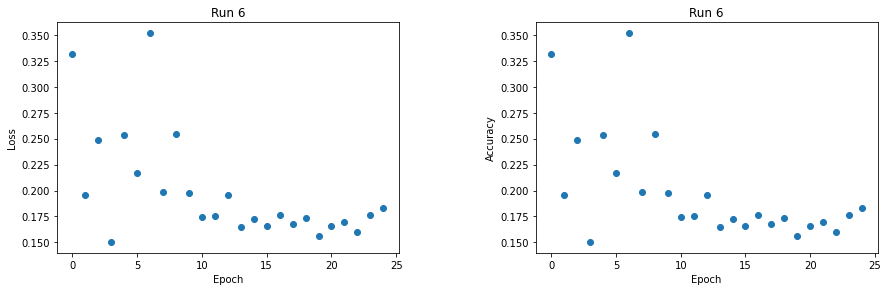

In [ ]:
# Create and run the sixth model with weight decay of 0.5
model_ft, optimizer_ft, exp_lr_scheduler, criterion = create_model( weight_decay=0.5)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
## Part e: For parameter set 6 weigth decay 0.5
# 
num_epochs_cpu6 = num_epochs_cpu.copy()
val_loss_cpu6 = val_loss_cpu.copy()
val_acc_cpu6 = val_loss_cpu.copy()
plt_valacc( num_epochs_cpu6, val_loss_cpu6, val_acc_cpu6, 'Run 6')

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6136 Acc: 0.6885
val Loss: 0.3957 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.4267 Acc: 0.7951
val Loss: 0.1992 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.5320 Acc: 0.7541
val Loss: 0.2687 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.3470 Acc: 0.8730
val Loss: 0.2982 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4172 Acc: 0.8443
val Loss: 0.6421 Acc: 0.8039

Epoch 5/24
----------
train Loss: 0.4001 Acc: 0.8443
val Loss: 0.2980 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4167 Acc: 0.8156
val Loss: 0.2316 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2388 Acc: 0.8975
val Loss: 0.1995 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3488 Acc: 0.8525
val Loss: 0.1856 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3005 Acc: 0.8648
val Loss: 0.1982 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2900 Acc: 0.8893
val Loss: 0.1799 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.2519 Acc: 0.8893
val Loss: 0.1949 Acc: 0.9150

Epoch 12/24
----------
t

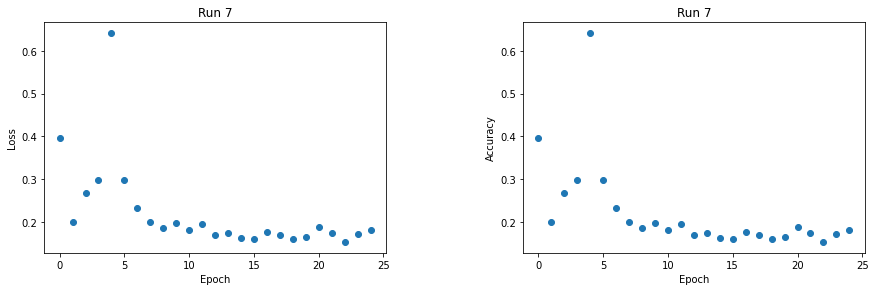

In [ ]:
# Create and run the 7th model with weight decay of 0.01
model_ft, optimizer_ft, exp_lr_scheduler, criterion = create_model( weight_decay=0.01)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
## Part e: For parameter set 7 weigth decay 0.01
# 
num_epochs_cpu7 = num_epochs_cpu.copy()
val_loss_cpu7 = val_loss_cpu.copy()
val_acc_cpu7 = val_loss_cpu.copy()
plt_valacc( num_epochs_cpu7, val_loss_cpu7, val_acc_cpu7, 'Run 7')

-------
(Modified Section)
-------
 

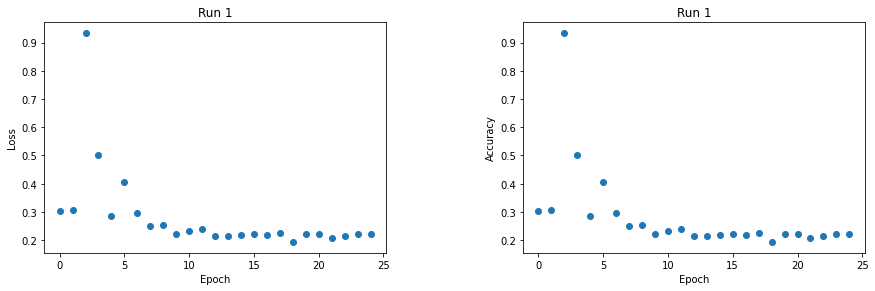

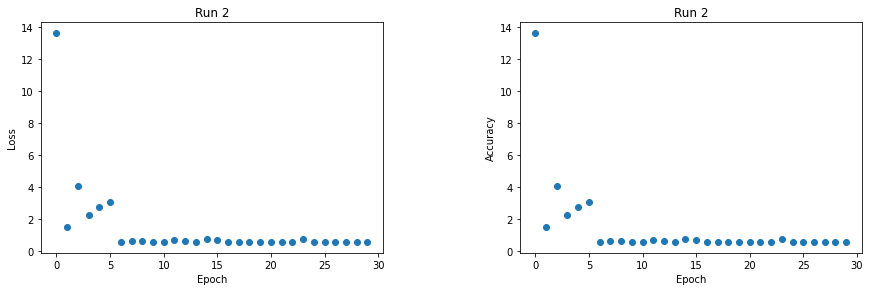

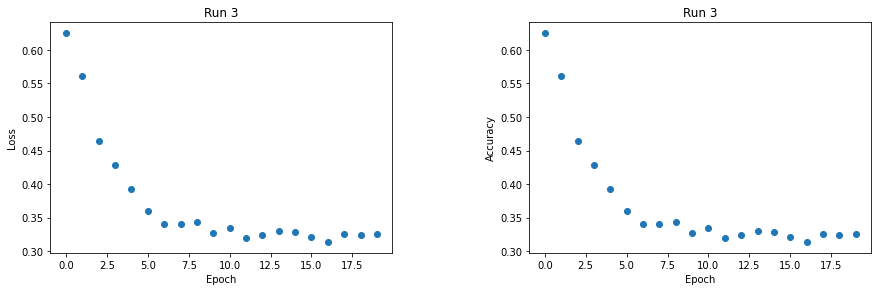

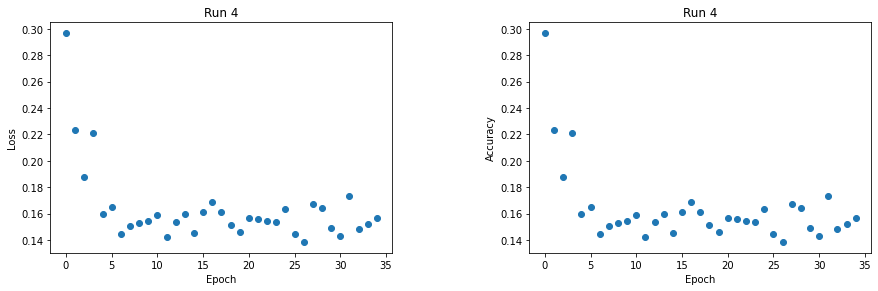

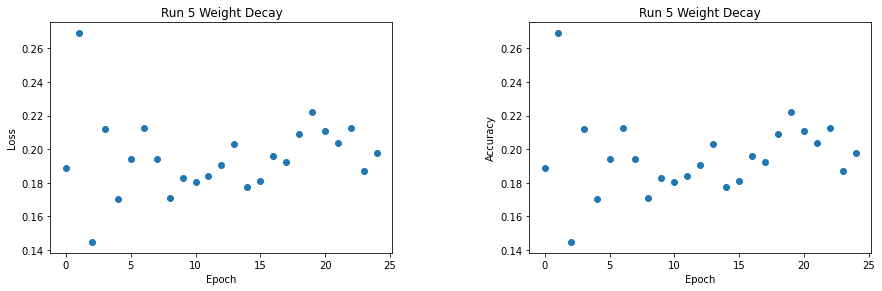

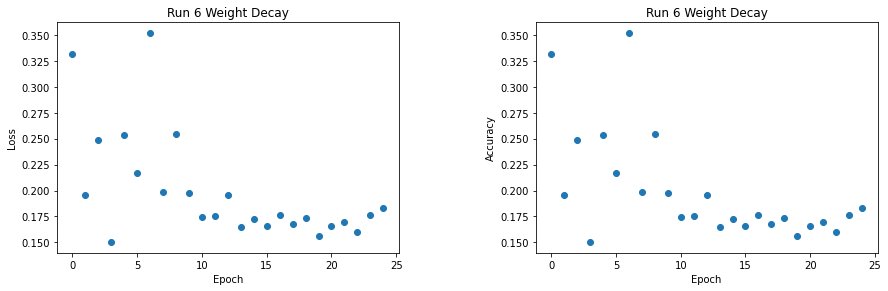

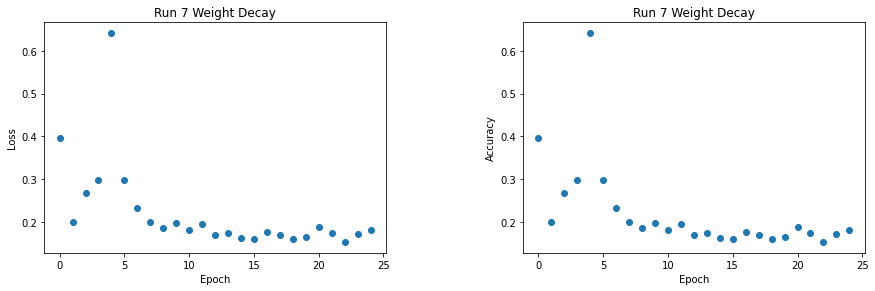

In [ ]:
# Plot all observations side by side
plt_valacc( num_epochs_cpu1, val_loss_cpu1, val_acc_cpu1, 'Run 1')
plt_valacc( num_epochs_cpu2, val_loss_cpu2, val_acc_cpu2, 'Run 2')
plt_valacc( num_epochs_cpu3, val_loss_cpu3, val_acc_cpu3, 'Run 3')
plt_valacc( num_epochs_cpu4, val_loss_cpu4, val_acc_cpu4, 'Run 4')
plt_valacc( num_epochs_cpu5, val_loss_cpu5, val_acc_cpu5, 'Run 5 Weight Decay')
plt_valacc( num_epochs_cpu6, val_loss_cpu6, val_acc_cpu6, 'Run 6 Weight Decay')
plt_valacc( num_epochs_cpu7, val_loss_cpu7, val_acc_cpu7, 'Run 7 Weight Decay')

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate


On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6481 Acc: 0.6516
val Loss: 0.4670 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5000 Acc: 0.7910
val Loss: 0.1675 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4231 Acc: 0.8279
val Loss: 0.1625 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.3606 Acc: 0.8279
val Loss: 0.1698 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.6961 Acc: 0.7213
val Loss: 0.1459 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.6794 Acc: 0.7418
val Loss: 0.1568 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.6910 Acc: 0.7500
val Loss: 0.7699 Acc: 0.7124

Epoch 7/24
----------
train Loss: 0.6115 Acc: 0.7623
val Loss: 0.1553 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3040 Acc: 0.8730
val Loss: 0.2022 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4165 Acc: 0.8525
val Loss: 0.1418 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.4370 Acc: 0.7992
val Loss: 0.1601 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3202 Acc: 0.8525
val Loss: 0.1841 Acc: 0.9477

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


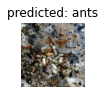

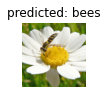

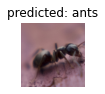

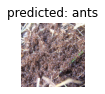

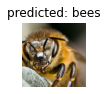

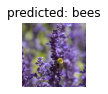

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



